In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

In [2]:
aspect_ratios = [0.5, 1.0, 2.0]
areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

In [3]:
def compute_dims():
    """Computes anchor box dimensions for all ratios and scales at all levels
    of the feature pyramid.
    """
    anchor_dims_all = []
    for area in areas:
        anchor_dims = []
        for ratio in aspect_ratios:
            anchor_height = np.math.sqrt(area / ratio)
            anchor_width = area / anchor_height
            dims = np.reshape(
                np.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
            )
            for scale in scales:
                anchor_dims.append(scale * dims)
        anchor_dims_all.append(np.stack(anchor_dims, axis=-2))
    return anchor_dims_all

In [4]:
anchor_dims = compute_dims()

In [5]:
num_anchors = len(aspect_ratios) * len(scales)
num_anchors

9

In [6]:
strides = [2 ** i for i in range(3, 8)]
strides

[8, 16, 32, 64, 128]

In [87]:
input_image = 800
level = 5
stride = strides[level - 3] 
feature_height = np.math.ceil(input_image / 2**level)
print("feature_height:", feature_height)
print("stride:", stride)

feature_height: 25
stride: 32


In [88]:
rx = np.arange(feature_height, dtype=np.float32) + 0.5
ry = np.arange(feature_height, dtype=np.float32) + 0.5 #for simplicity concider w=h
centers = np.stack(np.meshgrid(rx, ry), axis=-1)*stride
centers.shape

(25, 25, 2)

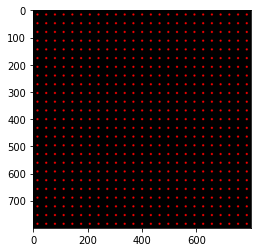

In [89]:
img = np.zeros([800,800,3], dtype='uint8')
for i in range(feature_height):
    for j in range(feature_height):
        x = int(centers[i, j, 0])
        y = int(centers[i, j, 1])
        point = (x, y)
        cv2.circle(img, point, 4, (255,0,0), -1)
plt.imshow(img)

In [90]:
centers = np.expand_dims(centers, axis=-2)
centers.shape

(25, 25, 1, 2)

In [91]:
centers = np.tile(centers, [1, 1, num_anchors, 1])
centers.shape

(25, 25, 9, 2)

In [92]:
dims = np.tile(
            anchor_dims[level - 3], [25, 25, 1, 1]
        )
dims.shape

(25, 25, 9, 2)

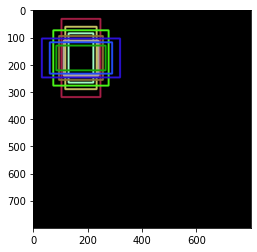

In [104]:
import cv2
import numpy as np
img = np.zeros([800,800,3], dtype='uint8')

for k in range(9):
    color = list(np.random.random(size=3) * 256)
    x1=int(centers[5,5,k,0]-dims[5,5,k,0]/2)
    y1=int(centers[5,5,k,1]-dims[5,5,k,1]/2)
    x2=int(centers[5,5,k,0]+dims[5,5,k,0]/2)
    y2=int(centers[5,5,k,1]+dims[5,5,k,1]/2)
    cv2.rectangle(img,(x1,y1), (x2,y2), color,5)
plt.imshow(img)

In [106]:
anchors = np.concatenate([centers, dims], axis=-1)
anchors.shape

(25, 25, 9, 4)

In [107]:
def _get_anchors(feature_height, feature_width, level):
    """Generates anchor boxes for a given feature map size and level

    Arguments:
      feature_height: An integer representing the height of the feature map.
      feature_width: An integer representing the width of the feature map.
      level: An integer representing the level of the feature map in the
        feature pyramid.

    Returns:
      anchor boxes with the shape
      `(feature_height * feature_width * num_anchors, 4)`
    """
    rx = np.arange(feature_width, dtype=np.float32) + 0.5
    ry = np.arange(feature_height, dtype=np.float32) + 0.5
    centers = np.stack(np.meshgrid(rx, ry), axis=-1) * strides[level - 3]
    centers = np.expand_dims(centers, axis=-2)
    centers = np.tile(centers, [1, 1, num_anchors, 1])
    dims = np.tile(
        anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
    )
    anchors = np.concatenate([centers, dims], axis=-1)
    return np.reshape(
        anchors, [feature_height * feature_width * num_anchors, 4]
    )

In [108]:
def get_anchors(image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.

        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.

        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            _get_anchors(
                np.math.ceil(image_height / 2 ** i),
                np.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return np.concatenate(anchors, axis=0)

In [109]:
all_anchors = get_anchors(800,800)
all_anchors.shape

(120087, 4)